# Week 3

In [10]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import parallel_backend
from tqdm.auto import tqdm
import kagglehub
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import logging
logging.getLogger("optuna").setLevel(logging.WARNING)
import json
import re


# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna
import scipy.stats as stats
from scipy import sparse


# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
)
import sklearn.model_selection._search as sk_search
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.model_selection._validation as sk_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction.text import CountVectorizer


# =============================
# Global
# =============================
random_state = 42
N_ROWS = 5_000_000  # sample size for all datasets
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# =============================
# Utils
# =============================
def dollar_format(x, pos=None):
    return f"${x:,.0f}"

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder, fname, **kwargs):
    fp = os.path.join(folder, fname)
    return pd.read_csv(fp, **kwargs) if os.path.exists(fp) else None

def list_csvs(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(".csv")]

def simple_random_sample(steam, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    n = len(steam)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        k = int(np.floor(frac * n))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        k = min(int(n_rows), n)
    if k >= n:
        return steam.copy()
    t0 = time.perf_counter()
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=k, replace=False)
    out = steam.iloc[idx].copy()
    t1 = time.perf_counter()
    print({"rows": n, "picked": int(len(out)), "frac": float(len(out) / n), "elapsed_sec": round(t1 - t0, 3)})
    return out

def stratified_sample(steam, y, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    y_arr = steam[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    n = len(steam)
    if len(y_arr) != n:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / n, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        return steam.copy()
    _, counts = np.unique(y_arr, return_counts=True)
    if np.any(counts < 2):
        print("Warning: some classes <2 samples; using simple sampling.")
        return simple_random_sample(steam, n_rows=use_n, frac=use_frac, random_state=random_state)
    t0 = time.perf_counter()
    idx = np.arange(n)
    _, test_idx, _, _ = train_test_split(
        idx, y_arr, test_size=test_size, stratify=y_arr, random_state=random_state
    )
    out = steam.iloc[test_idx].copy()
    t1 = time.perf_counter()
    print(
        {
            "rows": n,
            "picked": int(len(out)),
            "frac": float(len(out) / n),
            "elapsed_sec": round(t1 - t0, 3),
            "mode": "stratified",
        }
    )
    return out

# =============================
# Load Steam (sample first)
# =============================
steam_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Steam path:", steam_path, "\n", os.listdir(steam_path))

games = try_read_csv(steam_path, "games.csv", low_memory=False)
users = try_read_csv(steam_path, "users.csv", low_memory=False)
recommendations = try_read_csv(steam_path, "recommendations.csv", low_memory=False)

metadata = None
meta_fp = os.path.join(steam_path, "games_metadata.json")
if os.path.exists(meta_fp):
    metadata = pd.read_json(meta_fp, lines=True)

print(
    "Steam shapes:",
    {
        "games": None if games is None else games.shape,
        "users": None if users is None else users.shape,
        "recommendations": None if recommendations is None else recommendations.shape,
        "metadata": None if metadata is None else metadata.shape,
    },
)

steam = None
if recommendations is not None:
    # sample recommendations
    if "is_recommended" in recommendations.columns:
        recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=N_ROWS, random_state=random_state)
    else:
        recs_sample = simple_random_sample(recommendations, n_rows=N_ROWS, random_state=random_state)

    gm = games
    if metadata is not None and "app_id" in metadata.columns and games is not None and "app_id" in games.columns:
        gm = games.merge(metadata, on="app_id", how="left")

    steam = recs_sample
    if gm is not None and "app_id" in recs_sample.columns and "app_id" in gm.columns:
        steam = steam.merge(gm, on="app_id", how="left")
    if users is not None and "user_id" in steam.columns and "user_id" in users.columns:
        steam = steam.merge(users, on="user_id", how="left")

    print("steam:", steam.shape)

# =============================
# Load Olist
# =============================
olist_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("\nOlist path:", olist_path, "\n", os.listdir(olist_path))

olist_customers = try_read_csv(olist_path, "olist_customers_dataset.csv")
olist_geolocation = try_read_csv(olist_path, "olist_geolocation_dataset.csv")
olist_items = try_read_csv(olist_path, "olist_order_items_dataset.csv")
olist_payments = try_read_csv(olist_path, "olist_order_payments_dataset.csv")
olist_reviews = try_read_csv(olist_path, "olist_order_reviews_dataset.csv")
olist_orders = try_read_csv(olist_path, "olist_orders_dataset.csv")
olist_products = try_read_csv(olist_path, "olist_products_dataset.csv")
olist_sellers = try_read_csv(olist_path, "olist_sellers_dataset.csv")
olist_cat_trans = try_read_csv(olist_path, "product_category_name_translation.csv")

print(
    "Olist shapes:",
    {
        "customers": None if olist_customers is None else olist_customers.shape,
        "geolocation": None if olist_geolocation is None else olist_geolocation.shape,
        "items": None if olist_items is None else olist_items.shape,
        "payments": None if olist_payments is None else olist_payments.shape,
        "reviews": None if olist_reviews is None else olist_reviews.shape,
        "orders": None if olist_orders is None else olist_orders.shape,
        "products": None if olist_products is None else olist_products.shape,
        "sellers": None if olist_sellers is None else olist_sellers.shape,
        "category_translation": None if olist_cat_trans is None else olist_cat_trans.shape,
    },
)

olist = None
if all(x is not None for x in [olist_orders, olist_customers, olist_items, olist_products, olist_sellers]):
    # translated category names
    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    # enrich items with product and seller info
    items_ext = (
        olist_items.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    # average lat,lng per ZIP prefix
    if olist_geolocation is not None:
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    payments_agg = (
        olist_payments.groupby("order_id", as_index=False).agg(
            payment_value_total=("payment_value", "sum"),
            payment_installments_max=("payment_installments", "max"),
            payment_count=("payment_type", "count"),
        )
        if olist_payments is not None
        else None
    )

    reviews_agg = (
        olist_reviews.groupby("order_id", as_index=False).agg(
            review_score_mean=("review_score", "mean"),
            review_count=("review_id", "count"),
        )
        if olist_reviews is not None
        else None
    )

    olist = (
        olist_orders.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )
    if payments_agg is not None:
        olist = olist.merge(payments_agg, on="order_id", how="left")
    if reviews_agg is not None:
        olist = olist.merge(reviews_agg, on="order_id", how="left")

    print("olist:", olist.shape)

    # sample Olist
    olist = simple_random_sample(olist, n_rows=N_ROWS, random_state=random_state)
    print("olist sample:", olist.shape)

# Run immediately after loading/creating `olist`
base_cols = [
    "order_id","customer_id","order_status","order_purchase_timestamp",
    "order_approved_at","order_delivered_carrier_date",
    "order_delivered_customer_date","order_estimated_delivery_date",
    "customer_unique_id","customer_zip_code_prefix","customer_city",
    "customer_state","geolocation_lat","geolocation_lng","geo_points",
    "order_item_id","product_id","seller_id","shipping_limit_date","price",
    "freight_value","product_category_name","product_name_lenght",
    "product_description_lenght","product_photos_qty","product_weight_g",
    "product_length_cm","product_height_cm","product_width_cm",
    "product_category_name_english","seller_zip_code_prefix","seller_city",
    "seller_state","payment_value_total","payment_installments_max",
    "payment_count","review_score_mean","review_count"
]

idx_map = {}
cols_set = set(olist.columns)
for i, name in enumerate(base_cols):
    if i in cols_set:
        idx_map[i] = name
    if str(i) in cols_set:
        idx_map[str(i)] = name

olist = olist.rename(columns=idx_map)


# =============================
# Load Video Games Sales 2019
# =============================
vg2019_path = kagglehub.dataset_download("ashaheedq/video-games-sales-2019")
print("\nVG2019 path:", vg2019_path, "\n", os.listdir(vg2019_path))

sales = None
csvs = list_csvs(vg2019_path)
target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csvs else (csvs[0] if csvs else None)
if target_csv is not None:
    sales = pd.read_csv(os.path.join(vg2019_path, target_csv), low_memory=False)
    print("sales:", sales.shape, "| file:", target_csv)

    # sample VG2019
    if "Genre" in sales.columns:
        sales = stratified_sample(sales, y="Genre", n_rows=N_ROWS, random_state=random_state)
    else:
        sales = simple_random_sample(sales, n_rows=N_ROWS, random_state=random_state)
    print("sales sample:", sales.shape)
else:
    print("No CSV found in the video-games-sales-2019 dataset.")

# Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos=None):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

pd.set_option("display.float_format", lambda x: f"{x:.6f}")


# =============================
# Final summaries
# =============================
print("\nsteam sample:", None if steam is None else steam.shape)
print("olist sample:", None if olist is None else olist.shape)
print("sales sample:", None if sales is None else sales.shape)

Steam path: /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 
 ['recommendations.csv', 'users.csv', 'games.csv', 'games_metadata.json']
Steam shapes: {'games': (50872, 13), 'users': (14306064, 3), 'recommendations': (41154794, 8), 'metadata': (50872, 3)}
{'rows': 41154794, 'picked': 5000000, 'frac': 0.12149252891412844, 'elapsed_sec': 6.06, 'mode': 'stratified'}
steam: (5000000, 24)

Olist path: /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 
 ['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']
Olist shapes: {'customers': (99441, 5), 'geolocation': (1000163, 5), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7), 'orders': (99441,

In [11]:
def prepare_all(
    steam, olist, sales,
    top_k_tags=50, max_total_features=200,
    test_size=0.2, random_state=42
):
    # ---------- Steam ----------
    df = steam.copy()
    X = df.copy()

    for c in ["date", "date_release", "title", "description", "price_final", "price_original", "tags",
              "win", "mac", "linux", "steam_deck",
              "helpful", "funny", "hours", "user_reviews", "products", "reviews"]:
        if c not in X.columns:
            X[c] = np.nan

    # Dates
    X["date"] = pd.to_datetime(X["date"], errors="coerce")
    X["date_release"] = pd.to_datetime(X["date_release"], errors="coerce")
    X["days_since_release"] = (X["date"] - X["date_release"]).dt.days.clip(lower=0).fillna(0)
    X["review_year"] = X["date"].dt.year.fillna(0)
    X["review_month"] = X["date"].dt.month.fillna(0)
    X["review_dow"] = X["date"].dt.dayofweek.fillna(0)

    # Text lengths
    X["title_len"] = X["title"].fillna("").astype(str).str.len()
    X["desc_len"] = X["description"].fillna("").astype(str).str.len()

    # Logs
    for col in ["helpful", "funny", "hours", "user_reviews", "products", "reviews", "price_final", "price_original"]:
        X[col] = pd.to_numeric(X[col], errors="coerce")
        X[col + "_log1p"] = np.log1p(X[col])

    # Prices
    X["is_free"] = X["price_final"].eq(0).astype("int8")
    with np.errstate(divide="ignore", invalid="ignore"):
        X["discount_ratio"] = np.where(
            X["price_original"] > 0,
            1.0 - (X["price_final"] / X["price_original"]),
            0.0
        )
    X["discount_ratio"] = pd.Series(X["discount_ratio"]).clip(0, 1).fillna(0.0)

    # Platform flags
    for b in ["win", "mac", "linux", "steam_deck"]:
        if b not in X.columns:
            X[b] = 0
        X[b] = (X[b] == True).astype("int8")

    keep_dense = [
        "win", "mac", "linux", "steam_deck",
        "days_since_release", "review_year", "review_month", "review_dow",
        "title_len", "desc_len",
        "helpful_log1p", "funny_log1p", "hours_log1p",
        "user_reviews_log1p", "products_log1p", "reviews_log1p",
        "price_final_log1p", "price_original_log1p",
        "discount_ratio", "is_free"
    ]
    for c in keep_dense:
        if c not in X.columns:
            X[c] = np.nan

    steam_df = X[keep_dense].copy()
    steam_df = steam_df.fillna(steam_df.median(numeric_only=True))

    # Tags
    base_cols = steam_df.shape[1]
    allowed_tag_cols = max(0, min(top_k_tags, max_total_features - base_cols))
    if allowed_tag_cols > 0:
        tags_clean = (
            df["tags"].fillna("").astype(str).str.lower()
            .str.replace(r"[\[\]\"]", "", regex=True)
            .str.replace(";", ",").str.replace("/", ",")
        )
        vec = CountVectorizer(
            tokenizer=lambda s: [t.strip() for t in s.split(",") if t.strip()],
            lowercase=False,
            binary=True,
            max_features=allowed_tag_cols
        )
        tag_sparse = vec.fit_transform(tags_clean.values)
        kept_tag_names = [f"tag_{t}" for t in vec.get_feature_names_out()]
        tag_df = pd.DataFrame(tag_sparse.toarray(), columns=kept_tag_names, index=df.index)
        steam_df = pd.concat([steam_df, tag_df], axis=1)

    # Target
    steam_df = steam_df.assign(positive_ratio=pd.to_numeric(df.get("positive_ratio"), errors="coerce")).copy()
    steam_df["positive_ratio"] = steam_df["positive_ratio"].fillna(steam_df["positive_ratio"].median())

    # ---------- Olist ----------
    o = olist.copy()
    if "price" in o.columns:
        o = o[o["price"].notna()]
        o = o[o["price"] > 0]
        olist_y = o["price"].astype(float)
    else:
        o["price"] = np.nan
        olist_y = o["price"].astype(float)

    date_cols = [
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
        "shipping_limit_date",
    ]
    for c in date_cols:
        if c in o.columns:
            o[c] = pd.to_datetime(o[c], errors="coerce")
        else:
            o[c] = pd.NaT

    o["purchase_dayofweek"] = o["order_purchase_timestamp"].dt.dayofweek
    o["purchase_month"] = o["order_purchase_timestamp"].dt.month
    o["purchase_hour"] = o["order_purchase_timestamp"].dt.hour

    def to_hours(td):
        return td.dt.total_seconds() / 3600.0

    o["approval_delay_h"] = to_hours(o["order_approved_at"] - o["order_purchase_timestamp"])
    o["to_carrier_h"] = to_hours(o["order_delivered_carrier_date"] - o["order_purchase_timestamp"])
    o["to_customer_h"] = to_hours(o["order_delivered_customer_date"] - o["order_purchase_timestamp"])
    o["est_delivery_h"] = to_hours(o["order_estimated_delivery_date"] - o["order_purchase_timestamp"])
    o["limit_from_purchase_h"] = to_hours(o["shipping_limit_date"] - o["order_purchase_timestamp"])

    o["delivered_late"] = (
        (o["order_delivered_customer_date"] > o["order_estimated_delivery_date"])
    ).astype("Int64")

    for c in ["product_length_cm", "product_width_cm", "product_height_cm", "product_weight_g"]:
        if c not in o.columns:
            o[c] = np.nan
    o["product_volume_cm3"] = o["product_length_cm"] * o["product_width_cm"] * o["product_height_cm"]
    o["density_g_per_cm3"] = np.where(
        (o["product_volume_cm3"] > 0) & o["product_weight_g"].notna(),
        o["product_weight_g"] / o["product_volume_cm3"],
        np.nan,
    )

    for c in ["payment_installments_max", "payment_value_total", "payment_count"]:
        if c not in o.columns:
            o[c] = np.nan
    o["avg_installment_value"] = np.where(
        o["payment_installments_max"] > 0,
        o["payment_value_total"] / o["payment_installments_max"],
        np.nan,
    )
    o["payment_value_per_payment"] = np.where(
        o["payment_count"] > 0,
        o["payment_value_total"] / o["payment_count"],
        np.nan,
    )

    o["freight_value"] = o.get("freight_value", np.nan)
    o["freight_per_kg"] = np.where(
        o["product_weight_g"] > 0,
        o["freight_value"] / (o["product_weight_g"] / 1000.0),
        np.nan,
    )

    if "order_item_id" not in o.columns:
        o["order_item_id"] = 1
    o["is_multi_item_order"] = (o["order_item_id"] > 1).astype("Int64")

    if "product_category_name" in o.columns and "product_category_name_english" in o.columns:
        o["product_category"] = o["product_category_name_english"].fillna(o["product_category_name"])
        o = o.drop(columns=["product_category_name", "product_category_name_english"])
    elif "product_category_name_english" in o.columns:
        o["product_category"] = o["product_category_name_english"]
        o = o.drop(columns=["product_category_name_english"])
    elif "product_category_name" in o.columns:
        o["product_category"] = o["product_category_name"]
        o = o.drop(columns=["product_category_name"])
    else:
        o["product_category"] = "Unknown"

    for col in ["customer_city", "seller_city"]:
        if col in o.columns:
            s_ = o[col].fillna("Unknown")
            freq = s_.map(s_.value_counts(normalize=True))
            o[col + "_freq"] = freq.astype(float)
            o = o.drop(columns=[col])

    cat_cols = []
    for c in ["order_status", "customer_state", "seller_state", "product_category"]:
        if c in o.columns:
            cat_cols.append(c)
            o[c] = o[c].fillna("Unknown").astype("string")
    if cat_cols:
        o = pd.get_dummies(o, columns=cat_cols, dtype=np.uint8)

    o = o.drop(columns=[c for c in ["order_id", "customer_id", "customer_unique_id", "product_id", "seller_id"] if c in o.columns], errors="ignore")
    o = o.drop(columns=[c for c in date_cols if c in o.columns], errors="ignore")

    if "price" in o.columns:
        o = o.drop(columns=["price"])

    num_cols = o.select_dtypes(include=[np.number]).columns.tolist()
    for c in num_cols:
        med = o[c].median()
        o[c] = o[c].fillna(med)

    obj_cols = o.select_dtypes(include=["object"]).columns.tolist()
    for c in obj_cols:
        o[c] = o[c].fillna("Unknown").astype("string")

    olist_df = o.assign(price=olist_y).copy()
    olist_df["price"] = olist_df["price"].fillna(olist_df["price"].median())

    # ---------- Sales ----------
    s = sales.copy()

    for c in ["Global_Sales", "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"]:
        if c in s.columns:
            s[c] = pd.to_numeric(s[c], errors="coerce")

    region_cols = [c for c in ["NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"] if c in s.columns]
    if region_cols:
        s["region_sum"] = s[region_cols].sum(axis=1, skipna=True)
        need_fill = s["Global_Sales"].isna() | ((s["Global_Sales"] <= 0) & (s["region_sum"] > 0))
        s.loc[need_fill, "Global_Sales"] = s.loc[need_fill, "region_sum"]
        s = s.drop(columns=["region_sum"])

    s = s[s["Global_Sales"].notna()]
    sales_y = s["Global_Sales"].astype(float)

    leak_cols = ["NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales", "Total_Shipped", "Rank"]
    junk_cols = ["VGChartz_Score", "Vgchartzscore", "User_Score", "url", "img_url", "status", "Last_Update", "basename"]
    drop_now = [c for c in leak_cols + junk_cols if c in s.columns]

    if "Name" in s.columns:
        terms = ["remaster", "remastered", "hd", "definitive", "collection", "trilogy", "anniversary"]
        s["is_remaster"] = s["Name"].astype("string").str.lower().str.contains("|".join(terms), na=False).astype("Int64")
        s = s.drop(columns=["Name"])
    else:
        s["is_remaster"] = pd.Series(0, index=s.index, dtype="Int64")

    def platform_family(p):
        p = "" if pd.isna(p) else str(p).upper()
        if p.startswith("PS") or p in {"PSP", "PSV"}:
            return "PlayStation"
        if p.startswith("X") or p in {"XB", "XBLA"}:
            return "Xbox"
        if p in {"SWITCH", "WII", "WIIU", "GC", "N64", "SNES", "NES", "DS", "3DS", "GB", "GBC", "GBA"}:
            return "Nintendo"
        if p == "PC":
            return "PC"
        if p in {"DC", "DREAMCAST", "SAT", "GEN", "MD", "MEGADRIVE", "GG"}:
            return "Sega"
        if "ATARI" in p:
            return "Atari"
        return "Other"

    if "Platform" in s.columns:
        s["Platform_Family"] = s["Platform"].apply(platform_family)
        handhelds = {"DS", "3DS", "GB", "GBC", "GBA", "PSP", "PSV"}
        s["is_portable"] = s["Platform"].astype("string").str.upper().isin(handhelds).astype("Int64")
        s = s.drop(columns=["Platform"])
    else:
        s["Platform_Family"] = "Other"
        s["is_portable"] = pd.Series(0, index=s.index, dtype="Int64")

    if "Year" in s.columns:
        s["Year"] = pd.to_numeric(s["Year"], errors="coerce")
        s.loc[~s["Year"].between(1970, 2025, inclusive="both"), "Year"] = np.nan
        s["Decade"] = (s["Year"] // 10 * 10).astype("Int64").astype(str)
    else:
        s["Year"] = np.nan
        s["Decade"] = "<NA>"

    s = s.drop(columns=drop_now, errors="ignore")

    for col in ["Publisher", "Developer"]:
        if col in s.columns:
            series = s[col].fillna("Unknown")
            freq = series.map(series.value_counts(normalize=True))
            s[col + "_freq"] = freq.astype(float)
            s = s.drop(columns=[col])

    cat_cols = []
    for c in ["Genre", "ESRB_Rating", "Platform_Family", "Decade"]:
        if c in s.columns:
            cat_cols.append(c)
            s[c] = s[c].fillna("Unknown").astype("string")
    if cat_cols:
        s = pd.get_dummies(s, columns=cat_cols, dtype=np.uint8)

    if "Global_Sales" in s.columns:
        s = s.drop(columns=["Global_Sales"])

    num_cols = s.select_dtypes(include=[np.number]).columns.tolist()
    for c in num_cols:
        med = s[c].median()
        s[c] = s[c].fillna(med)

    obj_cols = s.select_dtypes(include=["object"]).columns.tolist()
    for c in obj_cols:
        s[c] = s[c].fillna("Unknown").astype("string")

    sales_df = s.assign(Global_Sales=sales_y).copy()
    sales_df["Global_Sales"] = sales_df["Global_Sales"].fillna(sales_df["Global_Sales"].median())

    # Print shapes of the dataframes
    print("\nsteam df shape:", steam_df.shape)
    print("olist df shape:", olist_df.shape)
    print("sales df shape:", sales_df.shape)

    # Helper to split and scale numeric non-binary columns
    def split_and_scale(df, target_col):
        X = df.drop(columns=[target_col])
        y = df[target_col].astype(float)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
        to_scale = []
        for c in num_cols:
            vals = pd.Series(X_train[c].dropna().unique())
            if len(vals) == 0:
                continue
            uniq = set(pd.to_numeric(vals, errors="coerce"))
            if len(uniq) <= 2 and uniq.issubset({0.0, 1.0}):
                continue
            to_scale.append(c)

        if to_scale:
            scaler = StandardScaler()
            X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
            X_test[to_scale] = scaler.transform(X_test[to_scale])

        return X_train, X_test, y_train, y_test

    steam_split = split_and_scale(steam_df, "positive_ratio")
    olist_split = split_and_scale(olist_df, "price")
    sales_split = split_and_scale(sales_df, "Global_Sales")

    return {"steam": steam_split, "olist": olist_split, "sales": sales_split}


splits = prepare_all(steam, olist, sales)

# Steam
(X_train_steam, X_test_steam, y_train_steam, y_test_steam) = splits["steam"]
# Olist
(X_train_olist, X_test_olist, y_train_olist, y_test_olist) = splits["olist"]
# Sales
(X_train_sales, X_test_sales, y_train_sales, y_test_sales) = splits["sales"]

print("\nsteam train:", X_train_steam.shape, y_train_steam.shape, "| test:", X_test_steam.shape, y_test_steam.shape)
print("olist train:", X_train_olist.shape, y_train_olist.shape, "| test:", X_test_olist.shape, y_test_olist.shape)
print("sales train:", X_train_sales.shape, y_train_sales.shape, "| test:", X_test_sales.shape, y_test_sales.shape)



steam df shape: (5000000, 71)
olist df shape: (112650, 168)
sales df shape: (55792, 49)

steam train: (4000000, 70) (4000000,) | test: (1000000, 70) (1000000,)
olist train: (90120, 167) (90120,) | test: (22530, 167) (22530,)
sales train: (44633, 48) (44633,) | test: (11159, 48) (11159,)


In [12]:
def run_selection(X, y, model,
                  direction="forward",
                  scoring="neg_mean_absolute_error",
                  cv=3,
                  max_features=30,
                  patience=5,
                  n_jobs=-1,
                  verbose=False,
                  plot=True):
    # support DataFrame or ndarray
    try:
        feature_names = list(X.columns)
        X_arr = X.values
    except AttributeError:
        X_arr = np.asarray(X)
        feature_names = [f"f{i}" for i in range(X_arr.shape[1])]

    n_features = X_arr.shape[1]

    if direction not in ("forward", "backward"):
        raise ValueError('direction must be "forward" or "backward"')

    best_scores = []
    best_feature_set_idx = []
    best_score = float("inf")
    consecutive_increases = 0

    if direction == "forward":
        selected_idx = []
        remaining_idx = list(range(n_features))
        previous_score = float("inf")
        added_names = []

        while remaining_idx and len(selected_idx) < max_features and consecutive_increases < patience:
            scores = {}
            for idx in remaining_idx:
                trial_idx = selected_idx + [idx]
                cv_score = -cross_val_score(
                    model,
                    X_arr[:, trial_idx],
                    y,
                    scoring=scoring,
                    cv=cv,
                    n_jobs=n_jobs
                ).mean()  # MAE (lower is better)
                scores[idx] = cv_score

            best_idx = min(scores, key=scores.get)
            current_score = scores[best_idx]

            if verbose:
                print(f"Added {feature_names[best_idx]} -> CV MAE = {current_score:.4f}")

            # track increases in a row
            if current_score > previous_score:
                consecutive_increases += 1
            else:
                consecutive_increases = 0

            selected_idx.append(best_idx)
            remaining_idx.remove(best_idx)
            added_names.append(feature_names[best_idx])
            best_scores.append(current_score)
            previous_score = current_score

            if current_score < best_score:
                best_score = current_score
                best_feature_set_idx = selected_idx.copy()

        selected_features = [feature_names[i] for i in selected_idx]
        best_feature_set = [feature_names[i] for i in best_feature_set_idx]

        if plot and len(best_scores) > 0:
            x = np.arange(1, len(best_scores) + 1)
            plt.figure(figsize=(10, 6))
            plt.plot(x, best_scores, marker=".")
            best_step = len(best_feature_set) if len(best_feature_set) > 0 else 1
            if 1 <= best_step <= len(best_scores):
                plt.plot([best_step], [best_score], marker="x")
            plt.xticks(x, added_names, rotation=60, ha="right", fontsize=6)
            plt.title("Forward Feature Selection and CV MAE")
            plt.xlabel("Feature Added")
            plt.ylabel("CV MAE")
            plt.grid()
            plt.ticklabel_format(axis="y", style="plain")
            plt.tight_layout()
            plt.show()

    else:
        # backward
        selected_idx = list(range(n_features))
        removed_names = []

        # baseline with all features
        previous_score = -cross_val_score(
            model,
            X_arr[:, selected_idx],
            y,
            scoring=scoring,
            cv=cv,
            n_jobs=n_jobs
        ).mean()  # MAE
        best_score = previous_score
        best_feature_set_idx = selected_idx.copy()

        if verbose:
            print(f"Start with all {len(selected_idx)} features -> CV MAE = {previous_score:.4f}")

        while len(selected_idx) > max_features and consecutive_increases < patience:
            scores = {}
            for idx in selected_idx:
                trial = [i for i in selected_idx if i != idx]
                cv_score = -cross_val_score(
                    model,
                    X_arr[:, trial],
                    y,
                    scoring=scoring,
                    cv=cv,
                    n_jobs=n_jobs
                ).mean()  # MAE
                scores[idx] = cv_score

            remove_idx = min(scores, key=scores.get)
            current_score = scores[remove_idx]

            if verbose:
                print(f"Removed {feature_names[remove_idx]} -> CV MAE = {current_score:.4f}")

            # track increases in a row
            if current_score > previous_score:
                consecutive_increases += 1
            else:
                consecutive_increases = 0

            removed_names.append(feature_names[remove_idx])
            selected_idx.remove(remove_idx)
            best_scores.append(current_score)
            previous_score = current_score

            if current_score < best_score:
                best_score = current_score
                best_feature_set_idx = selected_idx.copy()

        selected_features = [feature_names[i] for i in selected_idx]
        best_feature_set = [feature_names[i] for i in best_feature_set_idx]

        if plot and len(best_scores) > 0:
            x = np.arange(1, len(best_scores) + 1)
            plt.figure(figsize=(10, 6))
            plt.plot(x, best_scores, marker=".")
            # best step is where best_score first appears
            try:
                best_step = best_scores.index(best_score) + 1
                plt.plot([best_step], [best_score], marker="x")
            except ValueError:
                pass
            plt.xticks(x, removed_names, rotation=60, ha="right", fontsize=6)
            plt.title("Backward Feature Selection and CV MAE")
            plt.xlabel("Feature Removed")
            plt.ylabel("CV MAE")
            plt.grid()
            plt.ticklabel_format(axis="y", style="plain")
            plt.tight_layout()
            plt.show()

    print(f"Best Features: {best_feature_set}")
    print(f"Best CV MAE Score: {best_score:.4f}")

In [18]:

def compare_pcr_pls_mae(x_train, x_test, y_train, y_test):
    # Convert inputs
    Xtr = np.asarray(x_train)
    Xte = np.asarray(x_test)
    ytr = np.asarray(y_train).ravel()
    yte = np.asarray(y_test).ravel()

    # Choose a safe maximum number of components
    n_features = Xtr.shape[1]
    n_samples = Xtr.shape[0]
    max_components = int(min(n_features, n_samples, 25))
    ns = np.arange(1, max_components + 1)

    # Hold metrics
    mae_pcr, r2_pcr = [], []
    mae_pls, r2_pls = [], []

    # Evaluate each number of components
    for n in ns:
        # PCR pipeline: scale -> PCA -> Linear Regression
        pcr = Pipeline([
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=n)),
            ("reg", LinearRegression())
        ])
        pcr.fit(Xtr, ytr)
        y_pred_pcr = pcr.predict(Xte)
        mae_pcr.append(mean_absolute_error(yte, y_pred_pcr))
        r2_pcr.append(r2_score(yte, y_pred_pcr))

        # PLS pipeline: scale -> PLS
        pls = Pipeline([
            ("scaler", StandardScaler()),
            ("pls", PLSRegression(n_components=n))
        ])
        pls.fit(Xtr, ytr)
        y_pred_pls = pls.predict(Xte).ravel()
        mae_pls.append(mean_absolute_error(yte, y_pred_pls))
        r2_pls.append(r2_score(yte, y_pred_pls))

    mae_pcr = np.array(mae_pcr)
    mae_pls = np.array(mae_pls)
    r2_pcr = np.array(r2_pcr)
    r2_pls = np.array(r2_pls)

    # Pick best by lowest MAE
    best_pcr_n = int(ns[np.argmin(mae_pcr)])
    best_pls_n = int(ns[np.argmin(mae_pls)])

    # Refit best models for prediction plots
    best_pcr = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=best_pcr_n)),
        ("reg", LinearRegression())
    ]).fit(Xtr, ytr)

    best_pls = Pipeline([
        ("scaler", StandardScaler()),
        ("pls", PLSRegression(n_components=best_pls_n))
    ]).fit(Xtr, ytr)

    y_pred_pcr_best = best_pcr.predict(Xte)
    y_pred_pls_best = best_pls.predict(Xte).ravel()

    best_pcr_mae = mean_absolute_error(yte, y_pred_pcr_best)
    best_pls_mae = mean_absolute_error(yte, y_pred_pls_best)
    best_pcr_r2 = r2_score(yte, y_pred_pcr_best)
    best_pls_r2 = r2_score(yte, y_pred_pls_best)

    print(f"Best PCR components: {best_pcr_n} | MAE: {best_pcr_mae:.6f} | R2: {best_pcr_r2:.6f}")
    print(f"Best PLS components: {best_pls_n} | MAE: {best_pls_mae:.6f} | R2: {best_pls_r2:.6f}")

    # Plot MAE vs components
    plt.figure(figsize=(7, 5))
    plt.plot(ns, mae_pcr, marker="o", label="PCR MAE")
    plt.plot(ns, mae_pls, marker="s", label="PLS MAE")
    plt.xlabel("Number of components")
    plt.ylabel("MAE on test set")
    plt.title("PCR vs PLS: MAE by number of components")
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.gca()
    plt.tight_layout()

    # PCR predictions vs actual
    plt.figure(figsize=(6, 5))
    plt.scatter(yte, y_pred_pcr_best, alpha=0.7)
    low = float(min(yte.min(), y_pred_pcr_best.min()))
    high = float(max(yte.max(), y_pred_pcr_best.max()))
    plt.plot([low, high], [low, high])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"PCR Predictions vs Actual (n_components={best_pcr_n})")
    plt.grid(True, alpha=0.4)
    plt.gca()
    plt.tight_layout()

    # PLS predictions vs actual
    plt.figure(figsize=(6, 5))
    plt.scatter(yte, y_pred_pls_best, alpha=0.7)
    low = float(min(yte.min(), y_pred_pls_best.min()))
    high = float(max(yte.max(), y_pred_pls_best.max()))
    plt.plot([low, high], [low, high])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"PLS Predictions vs Actual (n_components={best_pls_n})")
    plt.grid(True, alpha=0.4)
    plt.gca()
    plt.tight_layout()

    # Show plots
    plt.show()


# Steam Reviews

Added linux -> CV MAE = 7.9048
Added is_free -> CV MAE = 7.6306
Added user_reviews_log1p -> CV MAE = 7.3843
Added tag_'2d' -> CV MAE = 7.2719
Added days_since_release -> CV MAE = 7.1771
Added tag_'massively multiplayer' -> CV MAE = 7.1095
Added tag_'free to play' -> CV MAE = 7.0315
Added tag_'pvp' -> CV MAE = 6.9767
Added mac -> CV MAE = 6.9267
Added tag_'cute' -> CV MAE = 6.8813
Added tag_'rpg' -> CV MAE = 6.8433
Added tag_'early access' -> CV MAE = 6.8104
Added price_final_log1p -> CV MAE = 6.7858
Added helpful_log1p -> CV MAE = 6.7623
Added tag_'co-op' -> CV MAE = 6.7439
Added tag_'great soundtrack' -> CV MAE = 6.7290
Added tag_'indie' -> CV MAE = 6.7223
Added tag_'open world' -> CV MAE = 6.7169
Added tag_'first-person' -> CV MAE = 6.7114
Added title_len -> CV MAE = 6.7065
Added tag_'violent' -> CV MAE = 6.7022
Added tag_'anime' -> CV MAE = 6.6978
Added tag_'pixel graphics' -> CV MAE = 6.6933
Added tag_'puzzle' -> CV MAE = 6.6874
Added tag_'family friendly' -> CV MAE = 6.6830
Added 

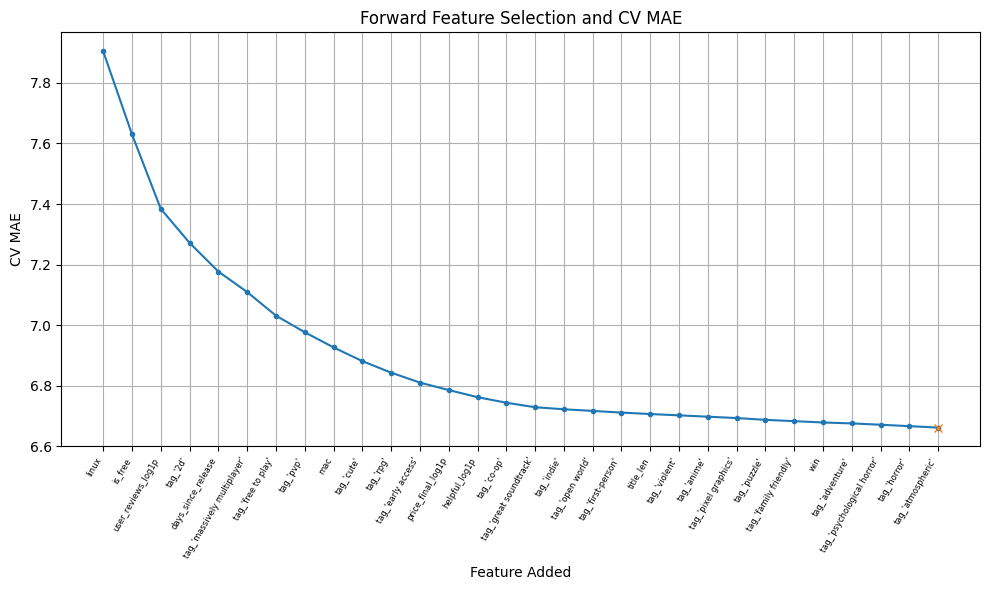

Best Features: ['linux', 'is_free', 'user_reviews_log1p', "tag_'2d'", 'days_since_release', "tag_'massively multiplayer'", "tag_'free to play'", "tag_'pvp'", 'mac', "tag_'cute'", "tag_'rpg'", "tag_'early access'", 'price_final_log1p', 'helpful_log1p', "tag_'co-op'", "tag_'great soundtrack'", "tag_'indie'", "tag_'open world'", "tag_'first-person'", 'title_len', "tag_'violent'", "tag_'anime'", "tag_'pixel graphics'", "tag_'puzzle'", "tag_'family friendly'", 'win', "tag_'adventure'", "tag_'psychological horror'", "tag_'horror'", "tag_'atmospheric'"]
Best CV MAE Score: 6.6618


In [15]:
run_selection(
    X_train_steam, y_train_steam, model=LinearRegression(),
    direction="forward",
    scoring="neg_mean_absolute_error",
    cv=3,
    max_features=30,
    patience=5,
    n_jobs=-1,
    verbose=True,
    plot=True
)

Start with all 70 features -> CV MAE = 6.6464
Removed hours_log1p -> CV MAE = 6.6425
Removed tag_'female protagonist' -> CV MAE = 6.6391
Removed tag_'sandbox' -> CV MAE = 6.6370
Removed tag_'character customization' -> CV MAE = 6.6351
Removed review_month -> CV MAE = 6.6331
Removed tag_'exploration' -> CV MAE = 6.6322
Removed tag_'third person' -> CV MAE = 6.6315
Removed tag_'comedy' -> CV MAE = 6.6310
Removed tag_'realistic' -> CV MAE = 6.6305
Removed discount_ratio -> CV MAE = 6.6300
Removed tag_'sci-fi' -> CV MAE = 6.6298
Removed tag_'action' -> CV MAE = 6.6297
Removed tag_'story rich' -> CV MAE = 6.6295
Removed tag_'controller' -> CV MAE = 6.6294
Removed review_dow -> CV MAE = 6.6293
Removed tag_'fantasy' -> CV MAE = 6.6293
Removed reviews_log1p -> CV MAE = 6.6294
Removed tag_'tactical' -> CV MAE = 6.6294
Removed tag_'difficult' -> CV MAE = 6.6296
Removed review_year -> CV MAE = 6.6297


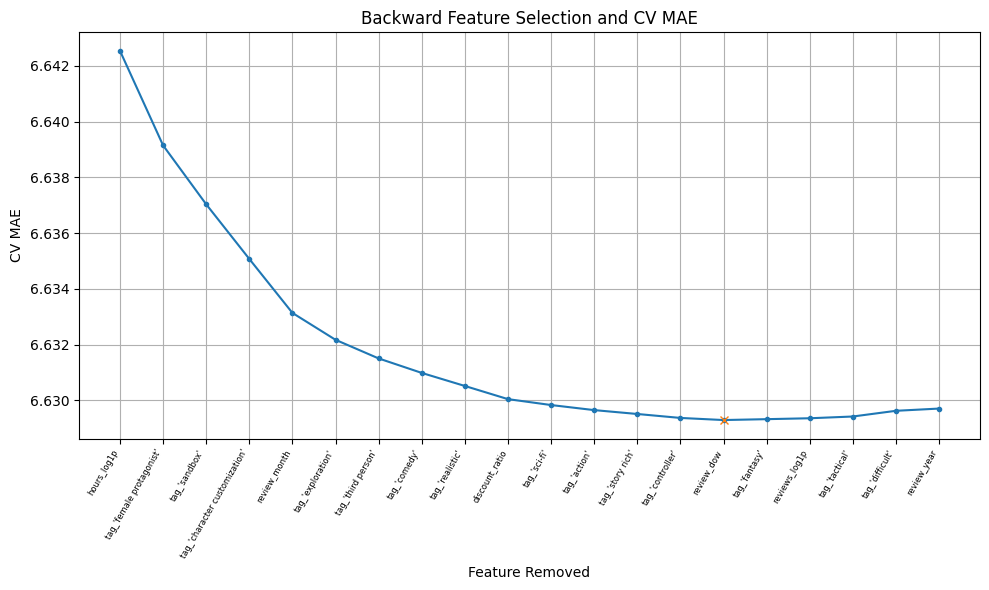

Best Features: ['win', 'mac', 'linux', 'steam_deck', 'days_since_release', 'review_year', 'title_len', 'desc_len', 'helpful_log1p', 'funny_log1p', 'user_reviews_log1p', 'products_log1p', 'reviews_log1p', 'price_final_log1p', 'price_original_log1p', 'is_free', "tag_'2d'", "tag_'adventure'", "tag_'anime'", "tag_'atmospheric'", "tag_'casual'", "tag_'classic'", "tag_'co-op'", "tag_'cute'", "tag_'difficult'", "tag_'early access'", "tag_'family friendly'", "tag_'fantasy'", "tag_'first-person'", "tag_'fps'", "tag_'free to play'", "tag_'funny'", "tag_'gore'", "tag_'great soundtrack'", "tag_'horror'", "tag_'indie'", "tag_'massively multiplayer'", "tag_'multiplayer'", "tag_'nudity'", "tag_'online co-op'", "tag_'open world'", "tag_'pixel graphics'", "tag_'platformer'", "tag_'psychological horror'", "tag_'puzzle'", "tag_'pvp'", "tag_'rpg'", "tag_'shooter'", "tag_'simulation'", "tag_'singleplayer'", "tag_'strategy'", "tag_'survival'", "tag_'tactical'", "tag_'third-person shooter'", "tag_'violent'"]

In [16]:
run_selection(
    X_train_steam, y_train_steam, model=LinearRegression(),
    direction="backward",
    scoring="neg_mean_absolute_error",
    cv=3,
    max_features=30,
    patience=5,
    n_jobs=-1,
    verbose=True,
    plot=True
)

Best PCR components: 23 | MAE: 7.126174 | R2: 0.222210
Best PLS components: 13 | MAE: 6.635084 | R2: 0.302260


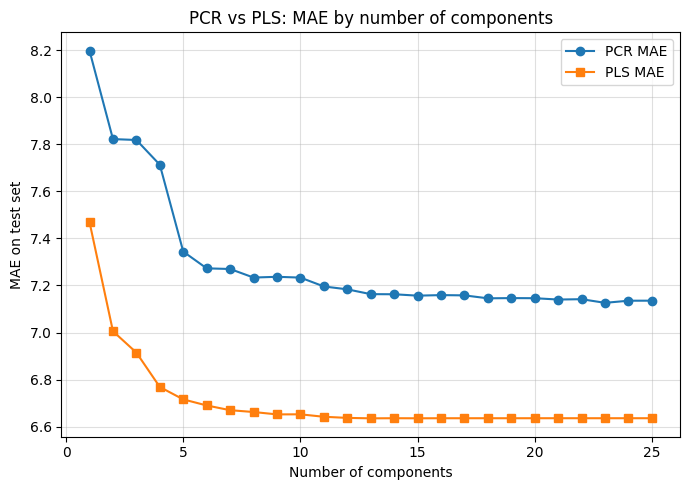

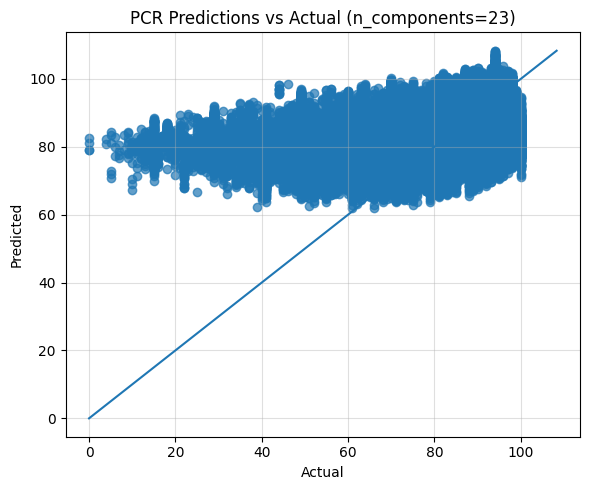

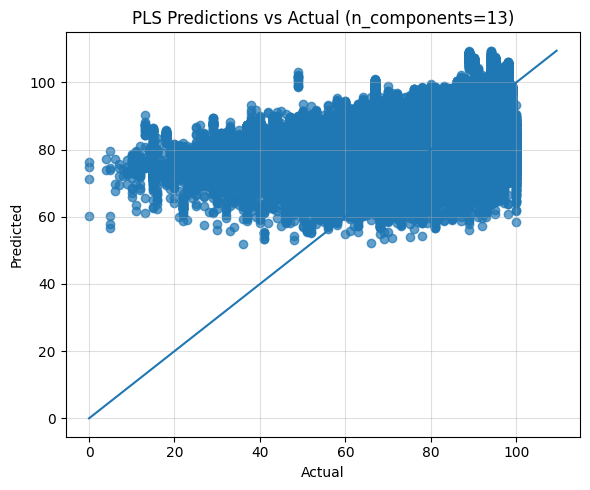

In [20]:
compare_pcr_pls_mae(X_train_steam, X_test_steam, y_train_steam, y_test_steam)

# Olist Transactions

Added payment_value_total -> CV MAE = 52.7978
Added order_item_id -> CV MAE = 46.2414
Added avg_installment_value -> CV MAE = 44.3523
Added product_weight_g -> CV MAE = 43.9707
Added product_category_watches_gifts -> CV MAE = 43.7556
Added product_category_cool_stuff -> CV MAE = 43.6301
Added seller_city_freq -> CV MAE = 43.4802
Added freight_per_kg -> CV MAE = 43.4029
Added product_category_sports_leisure -> CV MAE = 43.3358
Added payment_value_per_payment -> CV MAE = 43.2731
Added seller_state_BA -> CV MAE = 43.2181
Added product_category_telephony -> CV MAE = 43.1527
Added product_category_housewares -> CV MAE = 43.0900
Added approval_delay_h -> CV MAE = 43.0407
Added product_category_electronics -> CV MAE = 42.9915
Added seller_state_PE -> CV MAE = 42.9437
Added seller_state_PR -> CV MAE = 42.8989
Added product_category_garden_tools -> CV MAE = 42.8638
Added product_height_cm -> CV MAE = 42.8318
Added product_category_perfumery -> CV MAE = 42.8126
Added geolocation_lat -> CV MAE = 

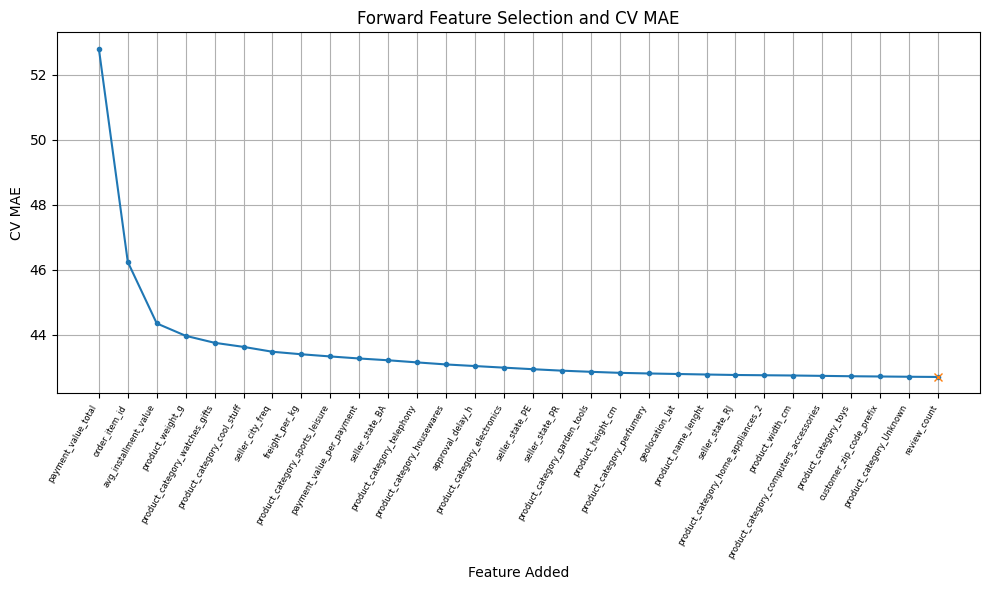

Best Features: ['payment_value_total', 'order_item_id', 'avg_installment_value', 'product_weight_g', 'product_category_watches_gifts', 'product_category_cool_stuff', 'seller_city_freq', 'freight_per_kg', 'product_category_sports_leisure', 'payment_value_per_payment', 'seller_state_BA', 'product_category_telephony', 'product_category_housewares', 'approval_delay_h', 'product_category_electronics', 'seller_state_PE', 'seller_state_PR', 'product_category_garden_tools', 'product_height_cm', 'product_category_perfumery', 'geolocation_lat', 'product_name_lenght', 'seller_state_RJ', 'product_category_home_appliances_2', 'product_width_cm', 'product_category_computers_accessories', 'product_category_toys', 'customer_zip_code_prefix', 'product_category_Unknown', 'review_count']
Best CV MAE Score: 42.7054


In [21]:
run_selection(
    X_train_olist, y_train_olist, model=LinearRegression(),
    direction="forward",
    scoring="neg_mean_absolute_error",
    cv=3,
    max_features=30,
    patience=5,
    n_jobs=-1,
    verbose=True,
    plot=True
)

Start with all 167 features -> CV MAE = 44.5488
Removed is_multi_item_order -> CV MAE = 44.0425
Removed freight_value -> CV MAE = 43.7774
Removed review_score_mean -> CV MAE = 43.7416
Removed delivered_late -> CV MAE = 43.7302
Removed product_name_lenght -> CV MAE = 43.7221
Removed geo_points -> CV MAE = 43.7160
Removed geolocation_lat -> CV MAE = 43.7103
Removed limit_from_purchase_h -> CV MAE = 43.7054
Removed to_carrier_h -> CV MAE = 43.7010
Removed to_customer_h -> CV MAE = 43.6967
Removed est_delivery_h -> CV MAE = 43.6925
Removed geolocation_lng -> CV MAE = 43.6884
Removed customer_zip_code_prefix -> CV MAE = 43.6851
Removed purchase_dayofweek -> CV MAE = 43.6821
Removed customer_city_freq -> CV MAE = 43.6809
Removed product_volume_cm3 -> CV MAE = 43.6800
Removed seller_state_PB -> CV MAE = 43.6795
Removed seller_state_BA -> CV MAE = 43.6674
Removed seller_state_RO -> CV MAE = 43.6636
Removed seller_state_RN -> CV MAE = 43.6609
Removed seller_state_PI -> CV MAE = 43.6587
Removed 

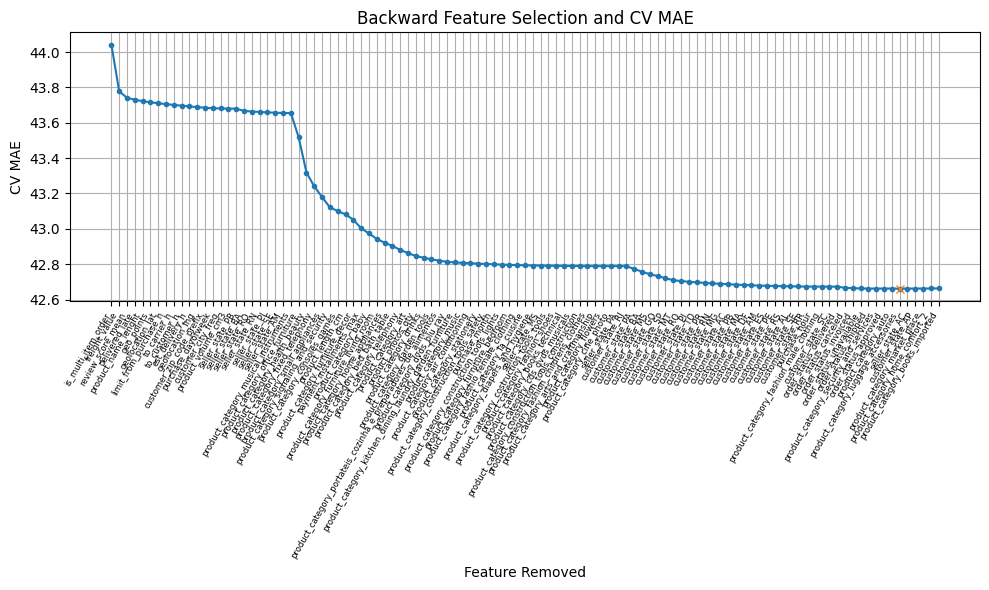

Best Features: ['order_item_id', 'product_description_lenght', 'product_weight_g', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix', 'payment_value_total', 'payment_count', 'review_count', 'approval_delay_h', 'density_g_per_cm3', 'avg_installment_value', 'payment_value_per_payment', 'freight_per_kg', 'seller_city_freq', 'order_status_processing', 'customer_state_AP', 'customer_state_CE', 'seller_state_AC', 'seller_state_CE', 'seller_state_DF', 'seller_state_ES', 'seller_state_GO', 'seller_state_MA', 'seller_state_MG', 'seller_state_MT', 'seller_state_PE', 'seller_state_PR', 'seller_state_RJ', 'seller_state_RS', 'seller_state_SC', 'seller_state_SP', 'product_category_Unknown', 'product_category_agro_industry_and_commerce', 'product_category_audio', 'product_category_books_general_interest', 'product_category_books_imported', 'product_category_christmas_supplies', 'product_category_computers', 'product_category_computers_accessories', 'product_category_cool_stuff', 'prod

In [22]:
run_selection(
    X_train_olist, y_train_olist, model=LinearRegression(),
    direction="backward",
    scoring="neg_mean_absolute_error",
    cv=3,
    max_features=30,
    patience=5,
    n_jobs=-1,
    verbose=True,
    plot=True
)

Best PCR components: 24 | MAE: 53.521267 | R2: 0.624164
Best PLS components: 20 | MAE: 43.046074 | R2: 0.749963


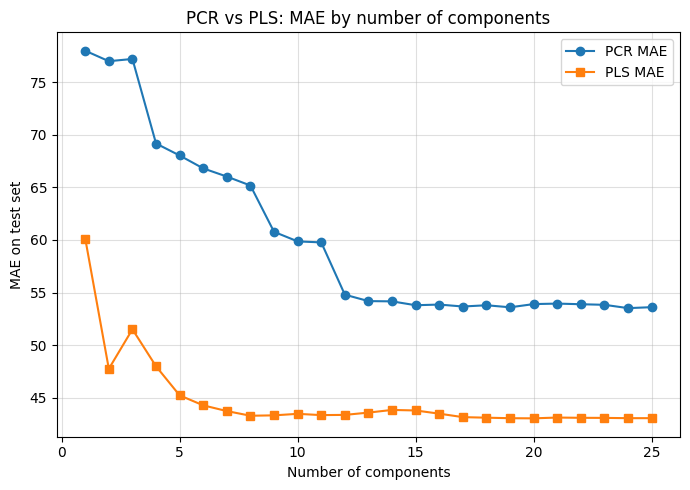

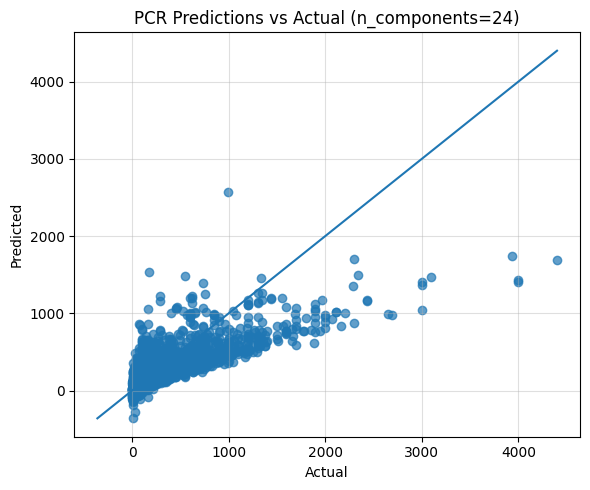

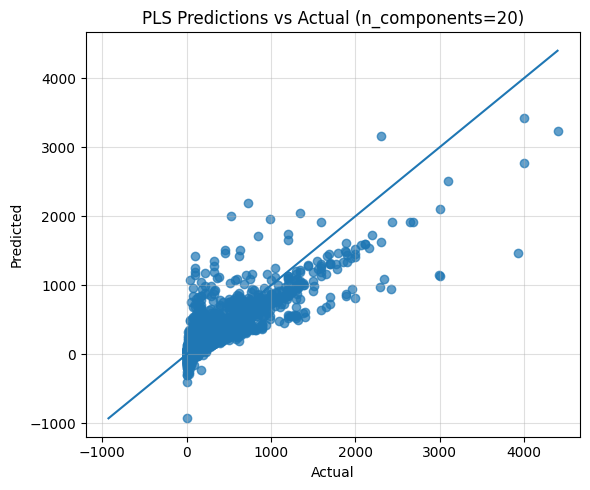

In [23]:
compare_pcr_pls_mae(X_train_olist, X_test_olist, y_train_olist, y_test_olist)

# Video Game Sales

Added ESRB_Rating_Unknown -> CV MAE = 0.1682
Added Genre_Sports -> CV MAE = 0.1672
Added ESRB_Rating_E -> CV MAE = 0.1666
Added ESRB_Rating_RP -> CV MAE = 0.1659
Added Genre_Music -> CV MAE = 0.1658
Added Genre_Fighting -> CV MAE = 0.1657
Added Decade_2010 -> CV MAE = 0.1657
Added Decade_2000 -> CV MAE = 0.1655
Added ESRB_Rating_AO -> CV MAE = 0.1654
Added ESRB_Rating_T -> CV MAE = 0.1654
Added ESRB_Rating_EC -> CV MAE = 0.1654
Added Platform_Family_Nintendo -> CV MAE = 0.1654
Added Genre_Board Game -> CV MAE = 0.1654
Added Developer_freq -> CV MAE = 0.1654
Added Genre_Simulation -> CV MAE = 0.1654
Added Decade_1970 -> CV MAE = 0.1654
Added ESRB_Rating_KA -> CV MAE = 0.1654
Added Genre_Education -> CV MAE = 0.1654
Added Genre_MMO -> CV MAE = 0.1654
Added Genre_Sandbox -> CV MAE = 0.1654


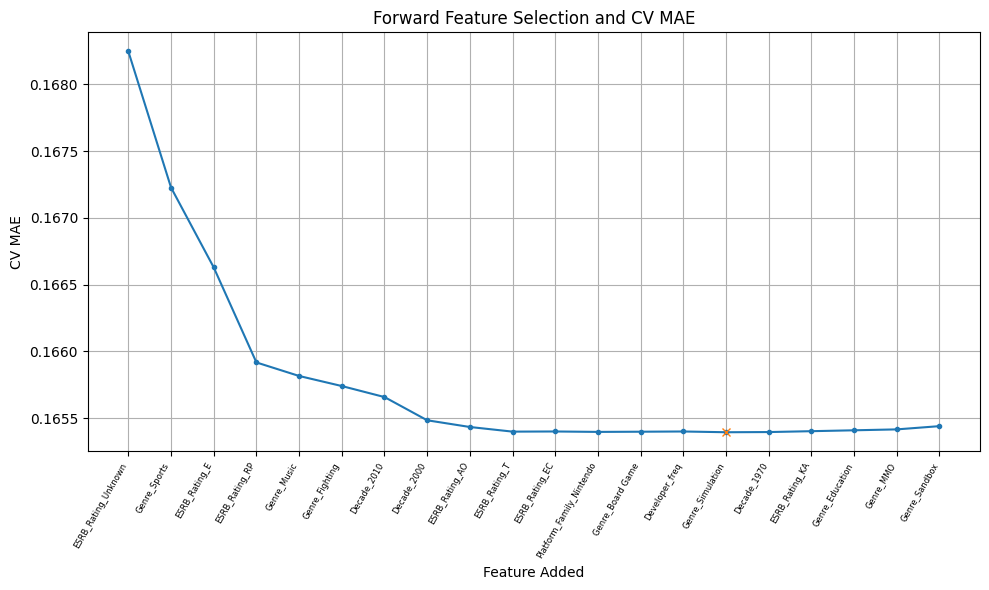

Best Features: ['ESRB_Rating_Unknown', 'Genre_Sports', 'ESRB_Rating_E', 'ESRB_Rating_RP', 'Genre_Music', 'Genre_Fighting', 'Decade_2010', 'Decade_2000', 'ESRB_Rating_AO', 'ESRB_Rating_T', 'ESRB_Rating_EC', 'Platform_Family_Nintendo', 'Genre_Board Game', 'Developer_freq', 'Genre_Simulation']
Best CV MAE Score: 0.1654


In [24]:
run_selection(
    X_train_sales, y_train_sales, model=LinearRegression(),
    direction="forward",
    scoring="neg_mean_absolute_error",
    cv=3,
    max_features=30,
    patience=5,
    n_jobs=-1,
    verbose=True,
    plot=True
)

Start with all 48 features -> CV MAE = 0.1868
Removed Critic_Score -> CV MAE = 0.1826
Removed is_remaster -> CV MAE = 0.1825
Removed Year -> CV MAE = 0.1825
Removed ESRB_Rating_RP -> CV MAE = 0.1825
Removed ESRB_Rating_KA -> CV MAE = 0.1825
Removed Developer_freq -> CV MAE = 0.1825
Removed Genre_Role-Playing -> CV MAE = 0.1825
Removed Genre_Sports -> CV MAE = 0.1820
Removed Genre_Shooter -> CV MAE = 0.1819
Removed Genre_Adventure -> CV MAE = 0.1817
Removed Genre_Action-Adventure -> CV MAE = 0.1817
Removed Genre_Fighting -> CV MAE = 0.1816
Removed Genre_Sandbox -> CV MAE = 0.1816
Removed Genre_Racing -> CV MAE = 0.1815
Removed Genre_Party -> CV MAE = 0.1815
Removed Genre_MMO -> CV MAE = 0.1815
Removed ESRB_Rating_Unknown -> CV MAE = 0.1815
Removed ESRB_Rating_M -> CV MAE = 0.1780


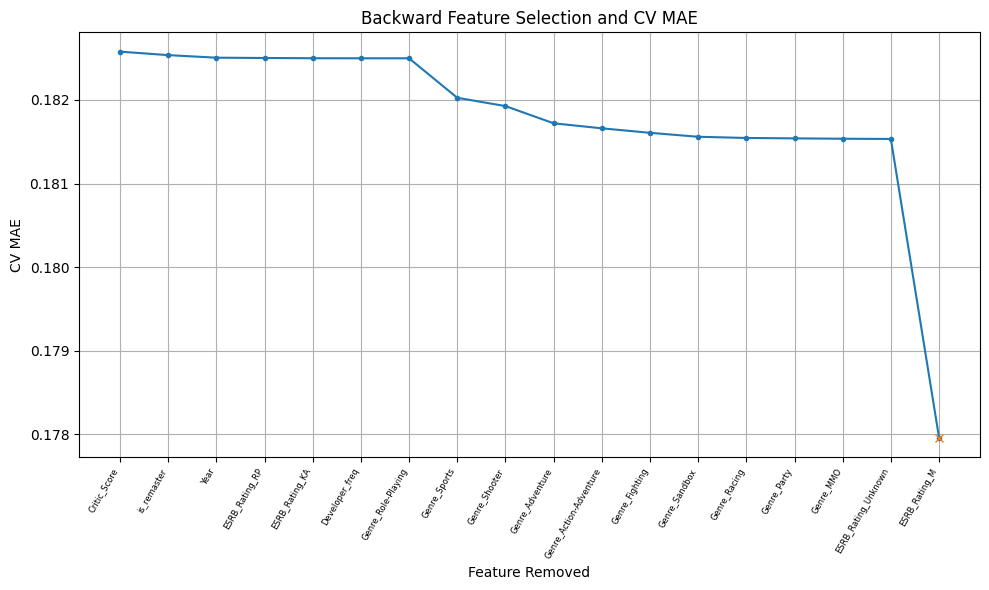

Best Features: ['is_portable', 'Publisher_freq', 'Genre_Action', 'Genre_Board Game', 'Genre_Education', 'Genre_Misc', 'Genre_Music', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Simulation', 'Genre_Strategy', 'Genre_Visual Novel', 'ESRB_Rating_AO', 'ESRB_Rating_E', 'ESRB_Rating_E10', 'ESRB_Rating_EC', 'ESRB_Rating_T', 'Platform_Family_Nintendo', 'Platform_Family_Other', 'Platform_Family_PC', 'Platform_Family_PlayStation', 'Platform_Family_Sega', 'Platform_Family_Xbox', 'Decade_1970', 'Decade_1980', 'Decade_1990', 'Decade_2000', 'Decade_2010', 'Decade_2020', 'Decade_<NA>']
Best CV MAE Score: 0.1780


In [25]:
run_selection(
    X_train_sales, y_train_sales, model=LinearRegression(),
    direction="backward",
    scoring="neg_mean_absolute_error",
    cv=3,
    max_features=30,
    patience=5,
    n_jobs=-1,
    verbose=True,
    plot=True
)

Best PCR components: 9 | MAE: 0.186981 | R2: 0.069584
Best PLS components: 4 | MAE: 0.189607 | R2: 0.114365


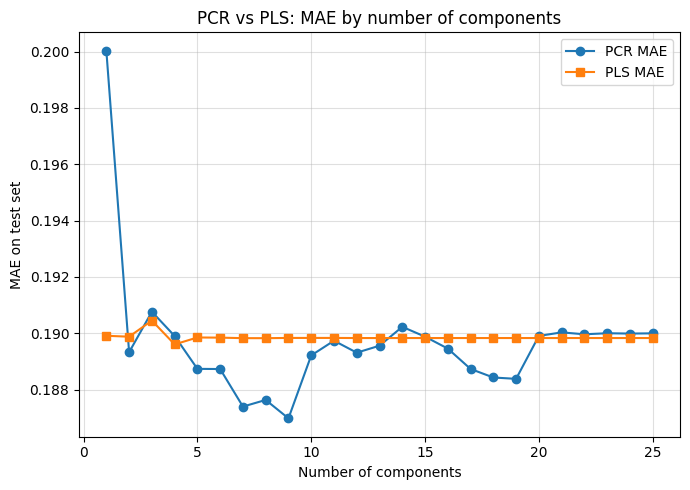

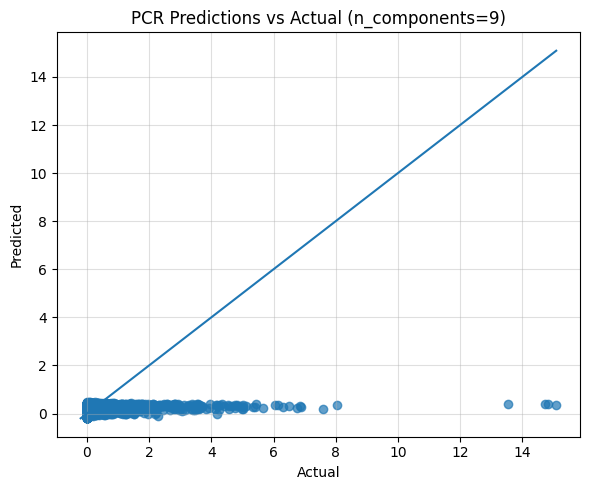

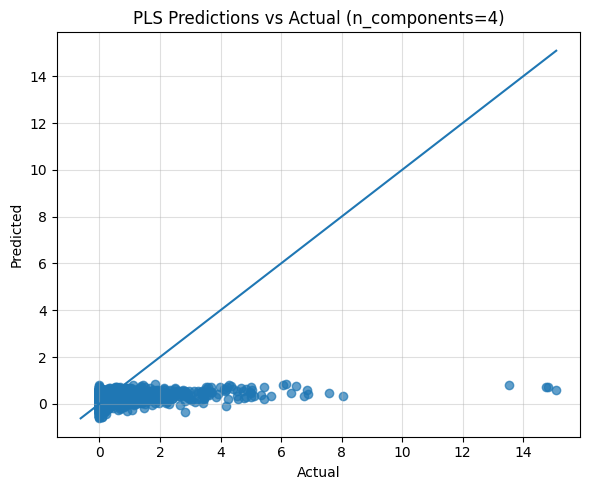

In [19]:
compare_pcr_pls_mae(X_train_sales, X_test_sales, y_train_sales, y_test_sales)